## Abordagem 2: Segmentação por distância de Mahalanobis

A segmentação por distância de Mahalanobis constitui uma abordagem mais sofisticada para isolamento de regiões de interesse no pipeline, considerando a covariância dos dados para uma segmentação mais precisa. Este método converte a imagem para o espaço de cor HSV e calcula a distância de Mahalanobis de cada pixel em relação a uma cor alvo, levando em conta a distribuição estatística das cores presentes na imagem.

A distância de Mahalanobis é uma métrica que normaliza a distância considerando a correlação entre as dimensões do espaço de cor, sendo particularmente eficaz para segmentação quando há variação na distribuição de cores. O algoritmo inicia coletando uma amostra de pixels próximos à cor alvo dentro de um intervalo empírico, calcula a matriz de covariância desta amostra, e em seguida computa a distância de Mahalanobis de todos os pixels em relação à média das amostras. Pixels com distância inferior ao limiar especificado formam a máscara de segmentação.

As demais etapas do pipeline são as mesmas que apresentadas no notebook anterior, e devido a isso, não foram includas suas descrições.

In [5]:
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import cv2
import numpy as np


def load_image(source):
    try:
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"could not load image, err: {e}")
        return None


def show_2_images(image1, image2, title1, title2):
    _, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG

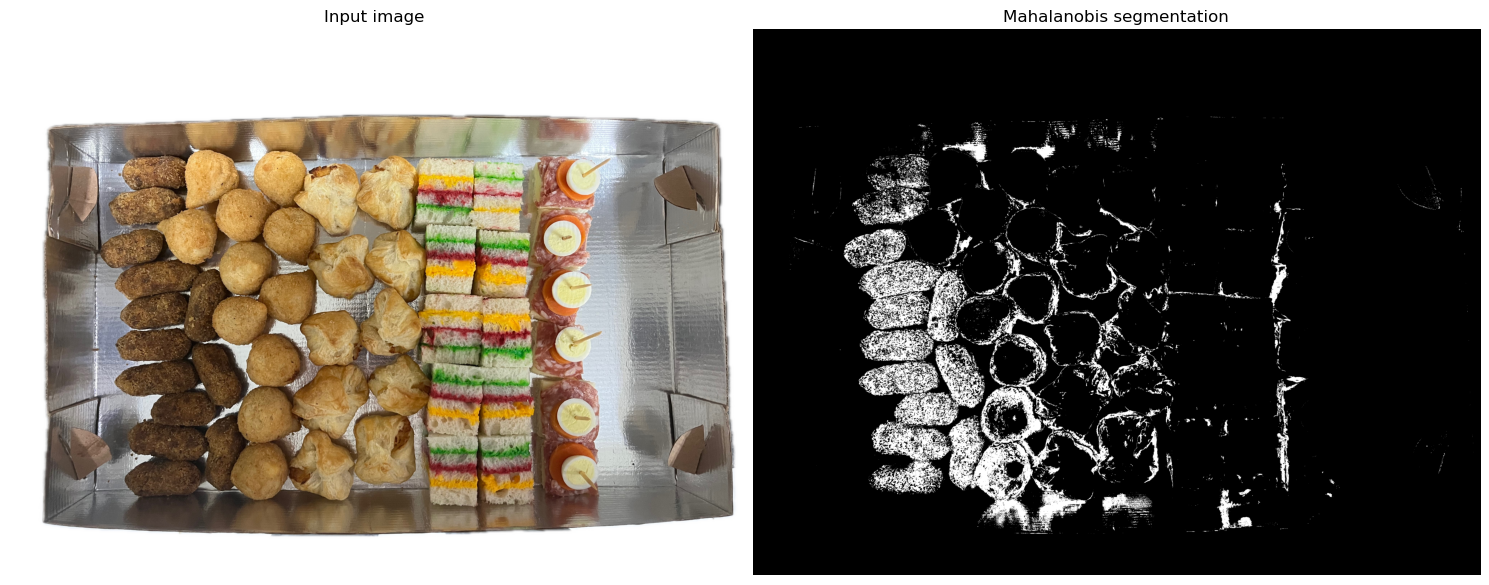

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3024, 4032), dtype=uint8)

In [6]:
from scipy.spatial.distance import mahalanobis


def segment_by_mahalanobis(image, target_color, lower_bound, upper_bound, threshold=10.0):
    global PIPELINE_IMG

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Reshape HSV image to (N, 3) for processing
    h, w = hsv_image.shape[:2]
    hsv_flat = hsv_image.reshape(-1, 3).astype(np.float32)

    mask_sample = cv2.inRange(hsv_image, lower_bound, upper_bound)
    sample_pixels = hsv_flat[mask_sample.flatten() > 0]
    
    if len(sample_pixels) < 3:
        # If no samples found, use a default covariance
        cov_matrix = np.eye(3) * 100
        mean_color = target_color.astype(np.float32)
    else:
        mean_color = np.mean(sample_pixels, axis=0)
        cov_matrix = np.cov(sample_pixels.T)
        
        # Ensure covariance matrix is invertible
        if np.linalg.matrix_rank(cov_matrix) < 3:
            cov_matrix += np.eye(3) * 0.1
    
    # Calculate inverse covariance matrix for mahalanobis function
    try:
        inv_cov = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov_matrix)
    
    # Calculate Mahalanobis distance for all pixels using scipy function
    distances = np.array([mahalanobis(pixel, mean_color, inv_cov) for pixel in hsv_flat])
    
    # Create binary mask based on threshold
    PIPELINE_IMG = (distances < threshold).astype(np.uint8).reshape(h, w) * 255
    #PIPELINE_IMG = (distances).astype(np.uint8).reshape(h, w)
    
    show_2_images(image, PIPELINE_IMG, 'Input image', 'Mahalanobis segmentation')
    
    return PIPELINE_IMG


# NOTE:
# brown colors HSV:
# [8, 130, 10]
# [10, 56, 127]
# [14, 140, 40]
# [15, 134, 135] -> identifies all with 8 threshold and 20 sample
# [10, 100, 80]  -> mid-brown
# [12, 110, 100] -> slightly lighter
# [8, 120, 90]   -> darker brown
#
# orange colors HSV:
# [17, 142, 190]

target_brown_color = np.array([8, 130, 10])

# interval range are the same from previous color segmentation
lower_bound = np.array([8, 130, 10])
upper_bound = np.array([24, 180, 140])

segment_by_mahalanobis(ORIGINAL_IMG, target_brown_color, lower_bound, upper_bound, threshold=2.3)

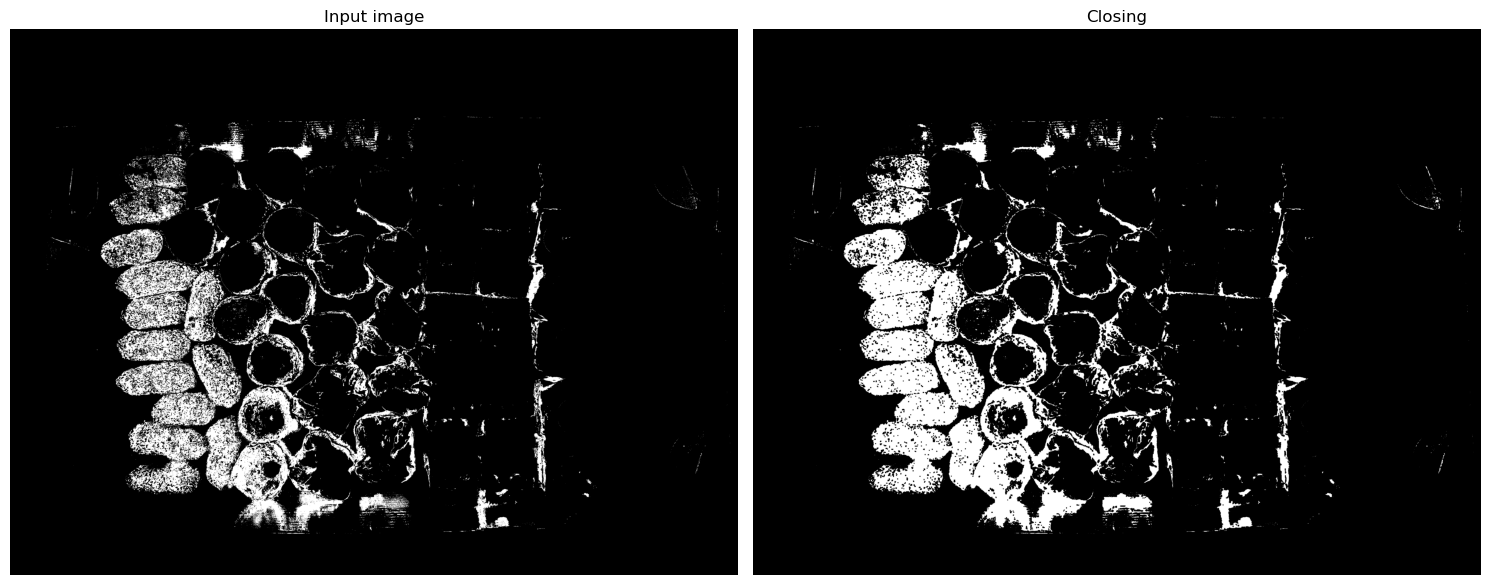

In [7]:
def apply_closing(image, kernel_size, iterations):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    PIPELINE_IMG = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Closing')


apply_closing(image=PIPELINE_IMG, kernel_size=(5,5), iterations=1)

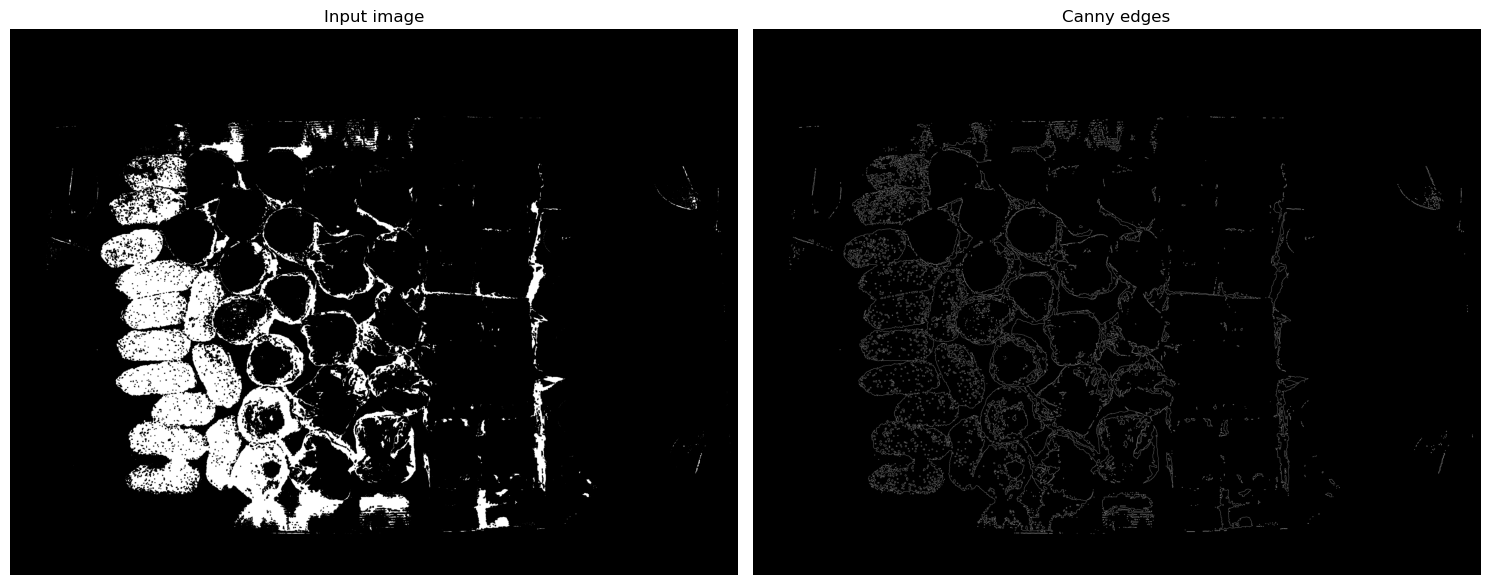

In [8]:
def apply_canny(image, threshold1, threshold2, apertureSize, L2gradient):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.bilateralFilter(gray_image, 50, 90, 90)
    PIPELINE_IMG = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Canny edges')


# NOTE: Original image best with gaussian blurred at 65/195 or bilaterealFilter at 15/45
#apply_canny(image=ORIGINAL_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

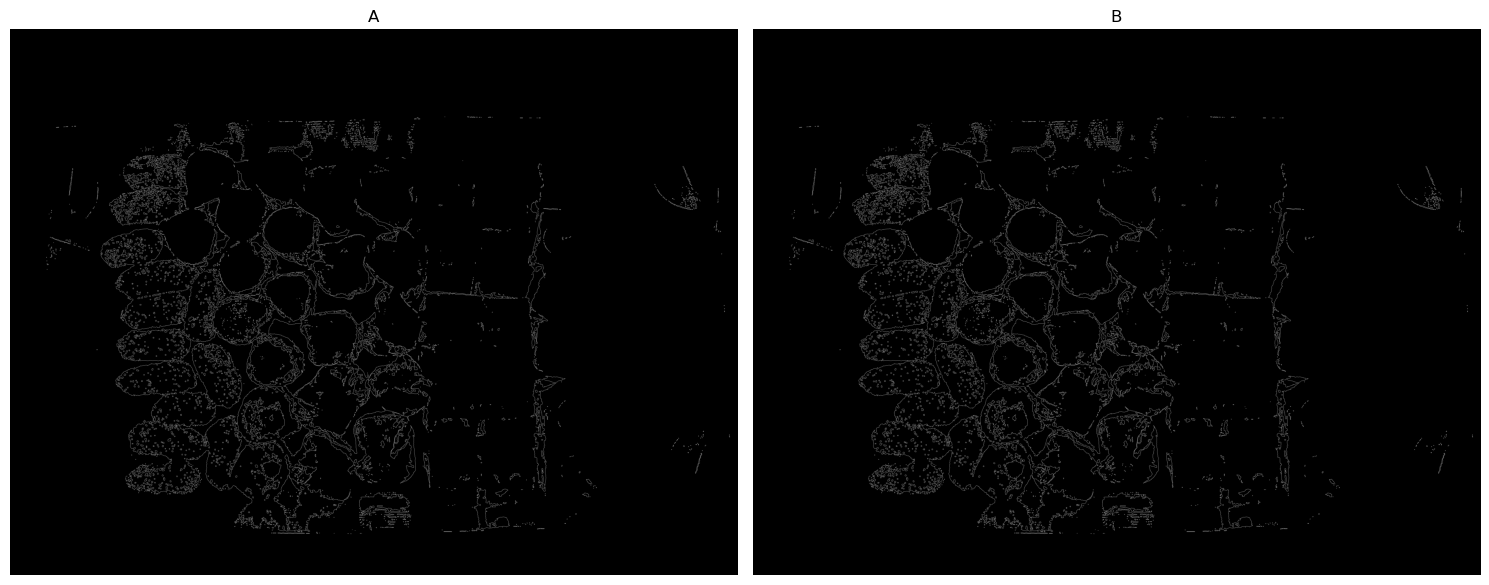

detected: 0


In [9]:
def count_ellipses_contours(image, area_min=500, area_ratio_tol=0.9, axis_ratio_max=5.0):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    _, th = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #mask = np.zeros_like(image)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min or len(cnt) < 5:
            continue
        
        ellipse = cv2.fitEllipse(cnt)
        (MA, ma) = ellipse[1]
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        ellipse_area = np.pi * a * b
        if ellipse_area <= 0:
            continue
        
        area_ratio = area / ellipse_area
        axis_ratio = (MA / ma) if ma > 0 else 999
        
        if area_ratio >= area_ratio_tol and axis_ratio <= axis_ratio_max:
            cv2.ellipse(out, ellipse, (0,255,0), 2)
            #cv2.drawContours(mask, [cnt], -1, 255, -1)
            count += 1

    return count, out


count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'A', 'B')

print('detected:', count)